## PMLDL Assignment 3: Diffusion. Text-to-Image Generation.
### Author: Nazgul Salikhova
### Email: n.salikhova@innopolis.university
### Group: B22-AAI-02

## Goal:

The goal of this task is to fine-tune the difussion model using a dataset of emojis, enabling it to generate new emojis based on text prompts.

## Download emoji dataset
from https://www.kaggle.com/datasets/subinium/emojiimage-dataset

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("subinium/emojiimage-dataset")

# print("Path to dataset files:", path)

## Download and import libraries

In [2]:
!pip install -q diffusers transformers torch torchvision datasets bitsandbytes

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL, DDPMPipeline
from transformers import CLIPTokenizer, CLIPTextModel
import os
import pandas as pd
from dataclasses import dataclass
import matplotlib.pyplot as plt
from diffusers.optimization import get_cosine_schedule_with_warmup
import bitsandbytes as bnb
from accelerate import Accelerator, notebook_launcher
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn.functional as F

## Initialize configuration class for training

In [4]:
@dataclass
class TrainingConfig:
    image_size: int = 256
    train_batch_size: int = 4
    eval_batch_size: int = 4
    num_epochs: int = 20
    gradient_accumulation_steps = 1
    learning_rate: float = 5e-6
    lr_warmup_steps: int = 500
    save_image_epochs: int = 10
    save_model_epochs: int = 30
    mixed_precision: str = "fp16"
    output_dir: str = "fine_tuned_diffuser_emoji"

    push_to_hub = False
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()

## Initialize Custom dataset for images

In [5]:
csv_path = "/kaggle/input/emojiimage-dataset/full_emoji.csv"
emoji_data = pd.read_csv(csv_path)

class EmojiDataset(Dataset):
    def __init__(self, root_dir, csv_data, transform=None):
        self.image_paths = []
        self.prompts = []
        
        prompt_dict = {f"{row['#']}.png": row['name'] for _, row in csv_data.iterrows()}
        
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                for file_name in os.listdir(subdir_path):
                    if file_name.lower().endswith(('png', 'jpg', 'jpeg')):
                        if file_name in prompt_dict:
                            self.image_paths.append(os.path.join(subdir_path, file_name))
                            self.prompts.append(prompt_dict[file_name])
                        else:
                            print(f"Warning: {file_name} not found in CSV.")
        
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGBA")
        white_background = Image.new("RGBA", image.size, (255, 255, 255, 255))
        image = Image.alpha_composite(white_background, image)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image) 
                    
        prompt = self.prompts[idx]
        return image, prompt

transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.CenterCrop(config.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

## Loading and Preparing Subset of Emoji Dataset for Training
For train dataset 2000 images were taken from Emoji dataset (mostly from Windows emojis)

In [ ]:
image_dir = "/kaggle/input/emojiimage-dataset/image"
train_dataset = EmojiDataset(image_dir, csv_data=emoji_data, transform=transform)

subset_size = 2000
subset_indices = list(range(subset_size))
train_subset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_subset, batch_size=config.train_batch_size, shuffle=True)

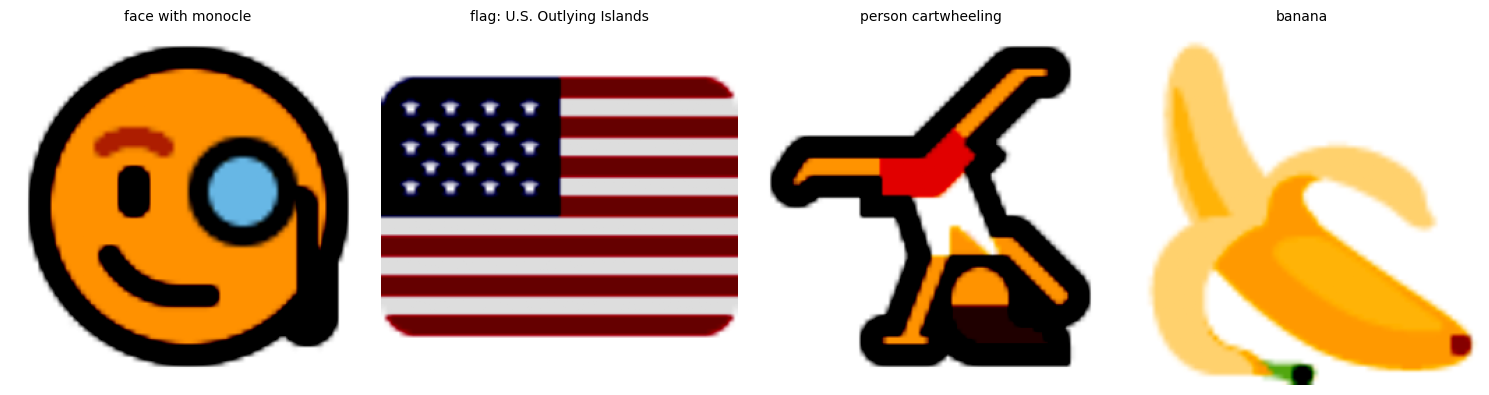

In [7]:
# Function to display images with prompts
def show_images(images, prompts, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        if i >= len(images):
            break
        image = images[i].permute(1, 2, 0).numpy()
        image = image / image.max()
        axes[i].imshow(image)
        truncated_prompt = (prompts[i][:50] + '...') if len(prompts[i]) > 50 else prompts[i]
        axes[i].set_title(truncated_prompt, fontsize=10)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

for images, prompts in train_dataloader:
    show_images(images, prompts, num_images=4)
    break

## Checking noise sheduler on image

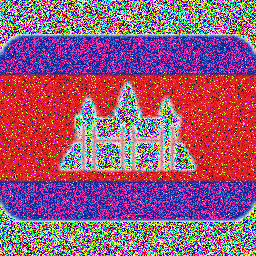

In [10]:
for images, prompts in train_dataloader:
    image = images[0].unsqueeze(0)
    sample_image = images[0].unsqueeze(0)
    prompt = prompts[0]
    break   
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## Loading Pretrained Models for Stable Diffusion

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "CompVis/stable-diffusion-v1-4"

tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(model_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")

vae.requires_grad_(False)
text_encoder.requires_grad_(False)

weight_dtype = torch.float32
text_encoder.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
unet.to(device, dtype=weight_dtype)
unet.train()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

## Optimizer setup

In [12]:
optimizer = bnb.optim.Adam8bit(unet.parameters(), lr=config.learning_rate) #reduces memory usage

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Training loop

In [13]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch
import torch.nn.functional as F
from diffusers import DDPMPipeline

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, tokenizer, text_encoder, vae):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        epoch_loss = 0

        for step, batch in enumerate(train_dataloader):
            images, prompt = batch
            clean_images = images
            prompts = prompt

            with torch.no_grad():
                latents = vae.encode(clean_images).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            tokenized_prompt = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(latents.device)
            with torch.no_grad():
                encoder_hidden_states = text_encoder(**tokenized_prompt).last_hidden_state

            noise = torch.randn(latents.shape, device=latents.device)
            bs = latents.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=latents.device,
                dtype=torch.long
            )
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()

            global_step += 1

        if accelerator.is_main_process:
            avg_loss = epoch_loss / len(train_dataloader)
            print(f"Epoch {epoch} completed. Average loss: {avg_loss:.4f}")
            
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"]
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [14]:
from accelerate import notebook_launcher
args = (config, unet, noise_scheduler, optimizer, train_dataloader, lr_scheduler, tokenizer, text_encoder, vae)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch 0 completed. Average loss: 0.0452
Epoch 1 completed. Average loss: 0.0370
Epoch 2 completed. Average loss: 0.0364
Epoch 3 completed. Average loss: 0.0331
Epoch 4 completed. Average loss: 0.0335
Epoch 5 completed. Average loss: 0.0345
Epoch 6 completed. Average loss: 0.0320
Epoch 7 completed. Average loss: 0.0327
Epoch 8 completed. Average loss: 0.0320
Epoch 9 completed. Average loss: 0.0306
Epoch 10 completed. Average loss: 0.0324
Epoch 11 completed. Average loss: 0.0301
Epoch 12 completed. Average loss: 0.0299
Epoch 13 completed. Average loss: 0.0307
Epoch 14 completed. Average loss: 0.0302
Epoch 15 completed. Average loss: 0.0286
Epoch 16 completed. Average loss: 0.0311
Epoch 17 completed. Average loss: 0.0300
Epoch 18 completed. Average loss: 0.0298
Epoch 19 completed. Average loss: 0.0295


## Model inference

In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def generate_and_display_images(prompts, output_folder="generations", pipeline=None, num_inference_steps=50):
    # Ensure the generations folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List to store generated image paths and prompts
    generated_images = []

    # Generate and save images for each prompt
    for i, prompt in enumerate(prompts):
        # Generate image
        image = pipeline(prompt, num_inference_steps=num_inference_steps).images[0]
        
        # Save image with prompt as filename
        filename = f"{output_folder}/image_{i+1}_{prompt.replace(' ', '_')}.png"
        image.save(filename)

        # Add image path and prompt to the list for displaying
        generated_images.append((filename, prompt))

    # Create a figure with a number of subplots based on the number of generated images
    fig, axes = plt.subplots(1, len(generated_images), figsize=(15, 5))  # 1 row, multiple columns

    # Iterate over the generated images and their prompts
    for ax, (image_path, prompt) in zip(axes, generated_images):
        # Open the image
        display_image = Image.open(image_path)
        
        # Display the image
        ax.imshow(display_image)
        ax.axis('off')  # Turn off axis for a cleaner view
        ax.set_title(prompt, fontsize=10)  # Set the prompt as the title

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

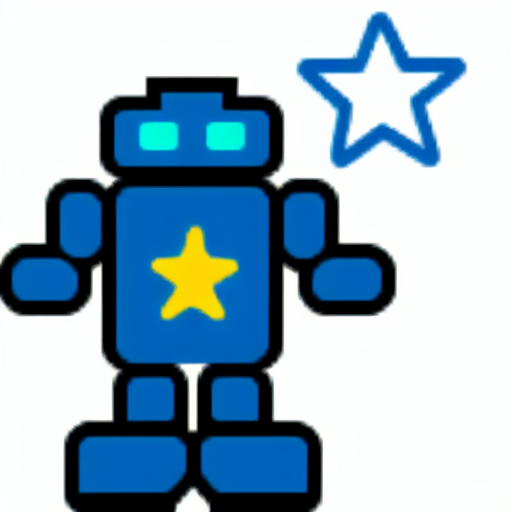

In [16]:
unet_path = "/kaggle/working/fine_tuned_diffuser_emoji/unet"
unet = UNet2DConditionModel.from_pretrained(unet_path)
pipeline = StableDiffusionPipeline(
    unet=unet,
    scheduler=noise_scheduler,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    feature_extractor=None,
    safety_checker=None 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)

# Generate an image from a prompt
prompt = "Blue Robot with a star"
generated_image = pipeline(prompt).images[0]
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

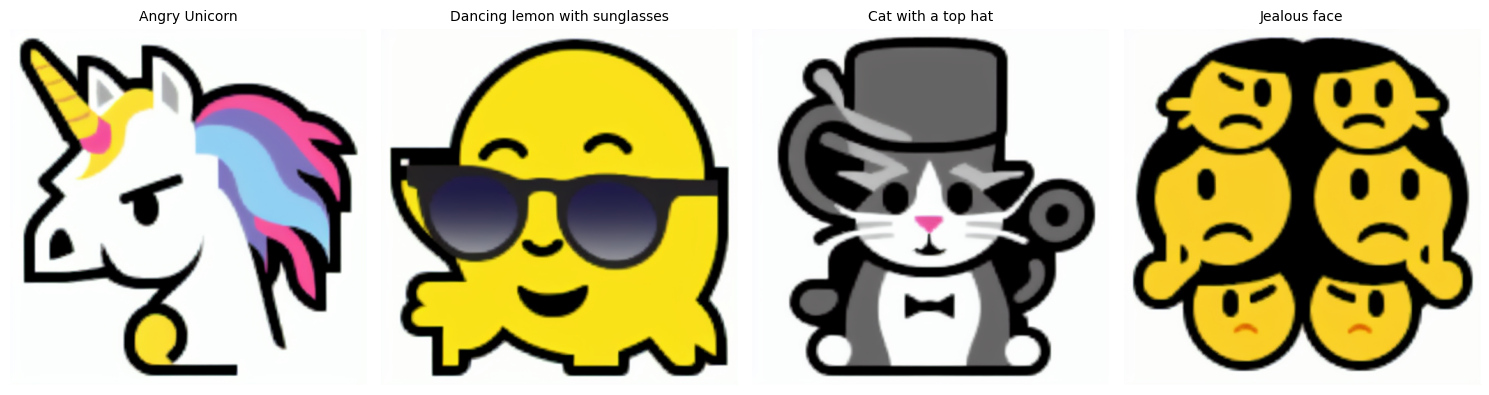

In [ ]:
prompts = [
    "Angry Unicorn",
    "Dancing lemon with sunglasses",
    "Cat with a top hat",
    "Jealous face"
]
# prompts = [
#     "Avocado men with a hat and flowers",
#     "Dancing lemon with sunglasses",
#     "Cat with a top hat",
#     "Smiling sun with glasses"
# ]
# prompts = [
#     "Happy girl with hearts",
#     "Happy sun with sunglasses",
#     "Dancing orange cat",
#     "Robot chef holding a pizza"
# ]

generate_and_display_images(prompts, output_folder="generations", pipeline=pipeline, num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

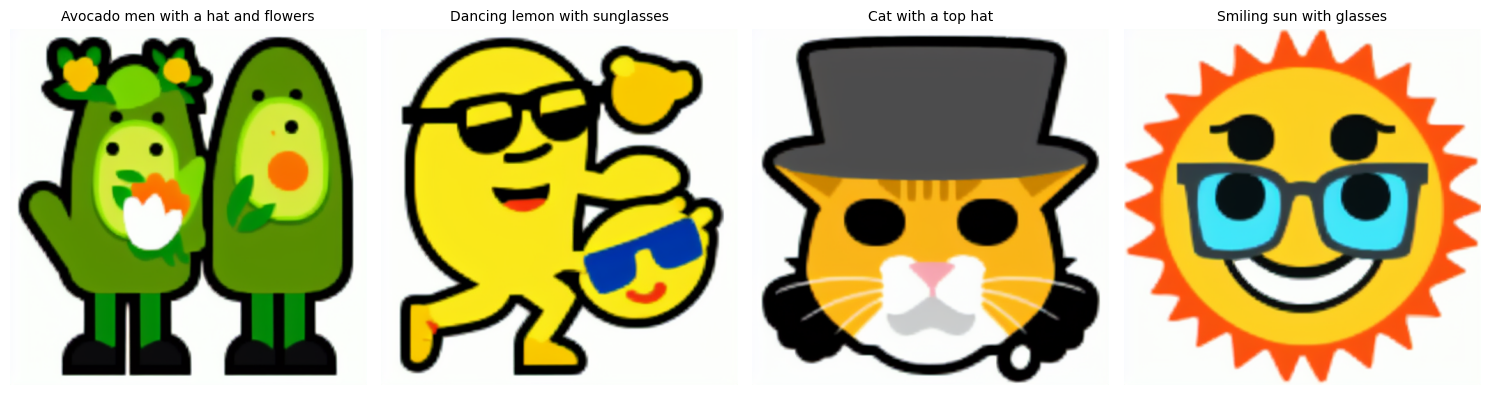

In [ ]:
# prompts = [
#     "Angry Unicorn",
#     "Dancing lemon with sunglasses",
#     "Cat with a top hat",
#     "Jealous face"
# ]
prompts = [
    "Avocado men with a hat and flowers",
    "Dancing lemon with sunglasses",
    "Cat with a top hat",
    "Smiling sun with glasses"
]
# prompts = [
#     "Happy girl with hearts",
#     "Happy sun with sunglasses",
#     "Dancing orange cat",
#     "Robot chef holding a pizza"
# ]

generate_and_display_images(prompts, output_folder="generations", pipeline=pipeline, num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

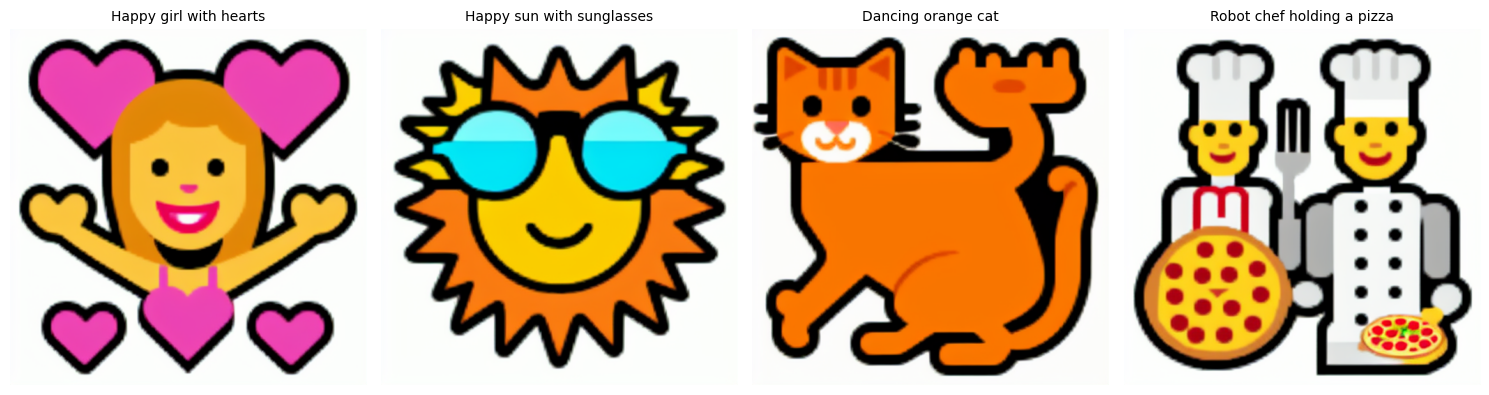

In [ ]:
# prompts = [
#     "Angry Unicorn",
#     "Dancing lemon with sunglasses",
#     "Cat with a top hat",
#     "Jealous face"
# ]
# prompts = [
#     "Avocado men with a hat and flowers",
#     "Dancing lemon with sunglasses",
#     "Cat with a top hat",
#     "Smiling sun with glasses"
# ]
prompts = [
    "Happy girl with hearts",
    "Happy sun with sunglasses",
    "Dancing orange cat",
    "Robot chef holding a pizza"
]

generate_and_display_images(prompts, output_folder="generations", pipeline=pipeline, num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

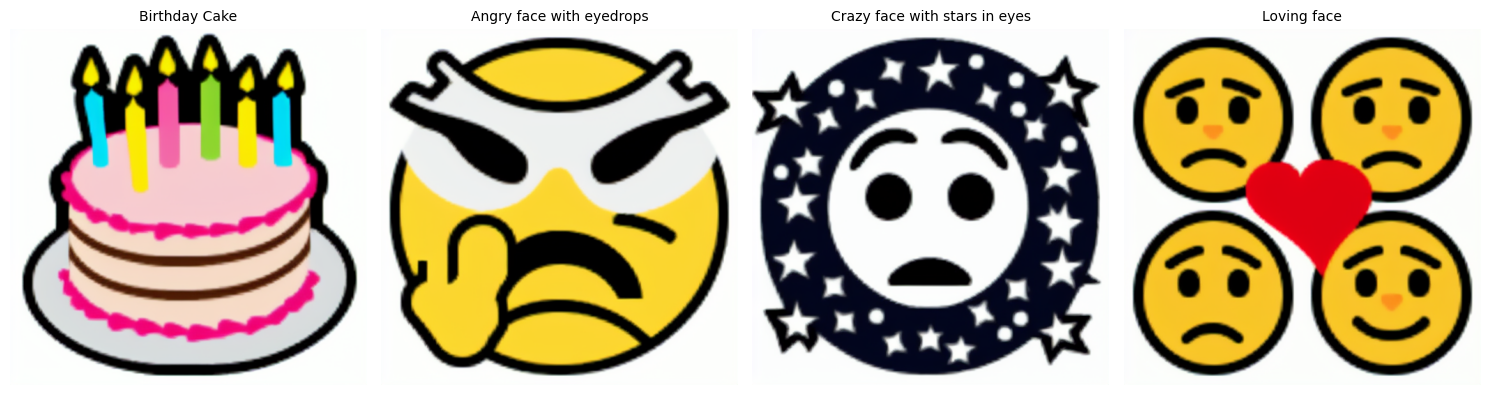

In [ ]:
prompts = [
    "Birthday Cake",
    "Angry face with eyedrops",
    "Crazy face with stars in eyes",
    "Loving face",
]

generate_and_display_images(prompts, output_folder="generations", pipeline=pipeline, num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

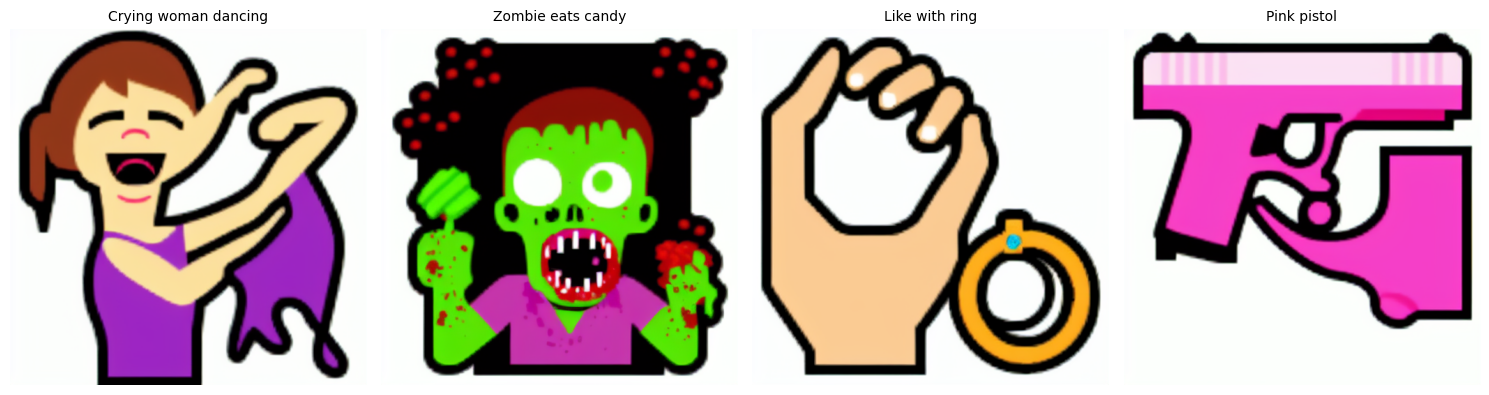

In [ ]:
prompts = [
    "Crying woman dancing",
    "Zombie eats candy",
    "Like with ring",
    "Pink pistol",
]

generate_and_display_images(prompts, output_folder="generations", pipeline=pipeline, num_inference_steps=50)